This exercise is the first assignment from [CS 224N](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1244/), taught in Winter 2024 at Stanford University. 

IF YOU TRY TO RUN THIS CODE, YOU MIGHT RUN INTO ISSUES WITH OUR PYTHON ENVIRONMENT AND NUMPY. EITHER RUN IT ON GOOGLE COLAB OR CREATE A NEW ENVIRONMENT, LIKE THIS:

name: cs224n
channels:
  - defaults
  - anaconda
dependencies:
  - jupyter
  - matplotlib
  - numpy
  - python>=3.8
  - ipykernel
  - scikit-learn
  - nltk
  - gensim

In [15]:
import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 8

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/mervetekgurler/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

In [16]:
def read_corpus(category="gold"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + \
            [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [17]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'western', 'mining', 'to', 'open', 'new', 'gold', 'mine', 'in', 'australia', 'western',
  'mining', 'corp', 'holdings', 'ltd', '&', 'lt', ';', 'wmng', '.', 's', '>', '(', 'wmc', ')',
  'said', 'it', 'will', 'establish', 'a', 'new', 'joint', 'venture', 'gold', 'mine', 'in', 'the',
  'northern', 'territory', 'at', 'a', 'cost', 'of', 'about', '21', 'mln', 'dlrs', '.', 'the',
  'mine', ',', 'to', 'be', 'known', 'as', 'the', 'goodall', 'project', ',', 'will', 'be', 'owned',
  '60', 'pct', 'by', 'wmc', 'and', '40', 'pct', 'by', 'a', 'local', 'w', '.', 'r', '.', 'grace',
  'and', 'co', '&', 'lt', ';', 'gra', '>', 'unit', '.', 'it', 'is', 'located', '30', 'kms', 'east',
  'of', 'the', 'adelaide', 'river', 'at', 'mt', '.', 'bundey', ',', 'wmc', 'said', 'in', 'a',
  'statement', 'it', 'said', 'the', 'open', '-', 'pit', 'mine', ',', 'with', 'a', 'conventional',
  'leach', 'treatment', 'plant', ',', 'is', 'expected', 'to', 'produce', 'about', '50', ',', '000',
  'ounces', 'of', 'gold'

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [18]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    distinct_words = {word for document in corpus for word in document}

    corpus_words = sorted(distinct_words)
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

Set comprehension inspo: https://medium.com/swlh/set-comprehension-in-python3-for-beginners-80561a9b4007

### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [19]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = np.zeros((n_words, n_words), dtype=np.int32)
    word2ind = {word: i for i, word in enumerate(words)}
    
    for document in corpus:
        for i, word in enumerate(document):
            word_index = word2ind[word]
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(document))
            for j in range(start, end):
                if i != j:  # don't count the word itself
                    window_word = document[j]
                    window_word_index = word2ind[window_word]
                    M[word_index, window_word_index] += 1

    return M, word2ind

References: 
https://numpy.org/doc/stable/reference/arrays.dtypes.html
https://realpython.com/python-enumerate/
Note to self:
start = max(i - window_size, 0)
end = min(i + window_size + 1, len(document))
is to make sure that we don't go over the bounds of the matrix. if we are in word at index 1 there is only index 0 so doing -4 pushes us off. until we get to index 4 we can only start at index 0 and after that we can start at index word -4. same goes for the end. this made more sense than the suggestion here: https://edstem.org/us/courses/51053/discussion/4111545 

### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [20]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10    # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

When looking through the functions in sklearn TruncatedSVD, I was not sure if I should use transform or fit_transform so I asked ChatGPT and got this answer (here abbrevated):
"Use fit_transform when you are applying a dimensionality reduction technique for the first time on your dataset. This ensures that the method learns the parameters from your specific dataset and then applies the transformation."

### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [21]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    for word in words:
        if word in word2ind:
            word_index = word2ind[word]
            x, y = M_reduced[word_index]
            plt.scatter(x, y, marker='x', color='red')
            plt.text(x, y, word, fontsize=9)
    plt.show()

I used the code from the suggested plot example but this plt.text(x+0.3, y+0.3, type, fontsize=9) does not work because it is moving the labels too far from the points.

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "gold" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run.

Running Truncated SVD over 2830 words...
Done.


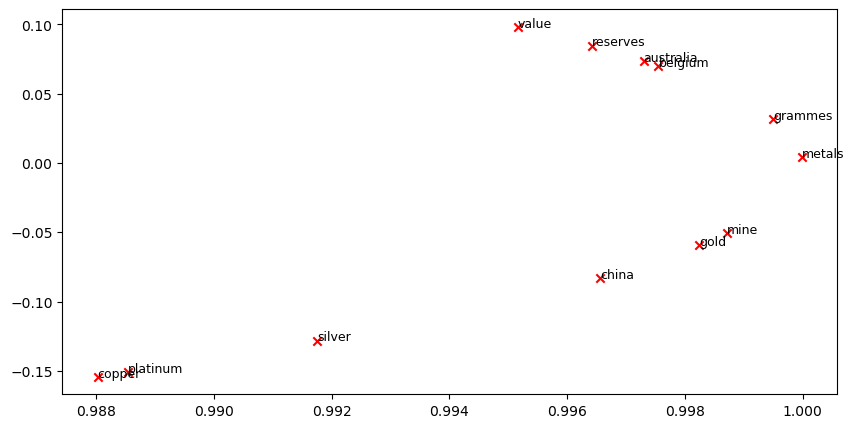

In [22]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [12]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [13]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [14]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]`.

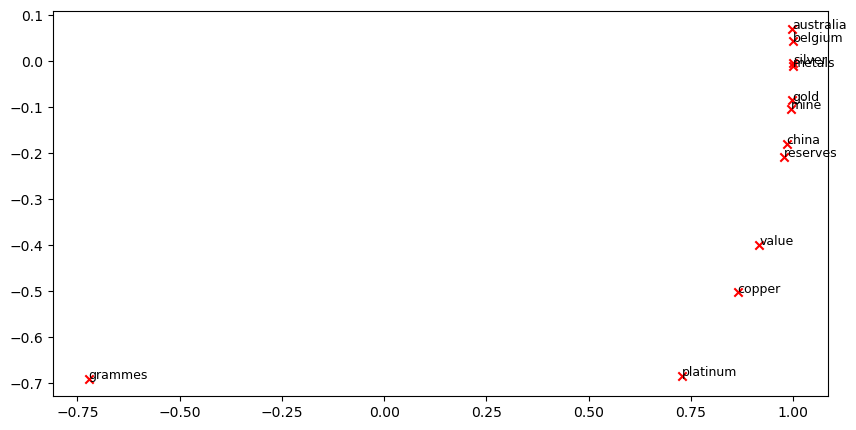

In [23]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'copper', 'belgium', 'australia', 'china', 'grammes', "mine"]

plot_embeddings(M_reduced_normalized, word2ind, words)

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="../img/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [24]:
# -----------------------------------------------------------------
# Hypothesis for Polysemes (words or phrases with different, but related, senses)
# and Homonyms (words that accidentally sound the same but are not related)
#
# mine, bank, lead, issue, bond, warrant, reserve, yield, credit, statement, load, cut, venture, tip
# -----------------------------------------------------------------

word = 'tip'
top_similar = wv_from_bin.most_similar(word, topn=10)

top_similar_words = [word for word, similarity in top_similar]
print("Top 10 similar words to '{}':".format(word))
print(top_similar_words)


Top 10 similar words to 'tip':
['tips', 'tipped', 'off', 'finger', 'tail', 'mouth', 'tipping', 'southernmost', 'corner', 'rounded']


Top 10 similar words to 'bank':
['banks', 'banking', 'central', 'financial', 'credit', 'lending', 'monetary', 'bankers', 'loans', 'investment']

Top 10 similar words to 'mine':
['mines', 'coal', 'mining', 'miners', 'miner', 'blast', 'ore', 'explosion', 'copper', 'nickel']

Top 10 similar words to 'lead':
['leads', 'led', 'leading', 'second', 'third', 'ahead', 'advantage', 'victory', 'win', 'fourth']

Top 10 similar words to 'issue':
['issues', 'question', 'matter', 'matters', 'topic', 'debate', 'subject', 'dispute', 'questions', 'resolved']

Top 10 similar words to 'bond':
['bonds', 'treasury', 'yields', 'yield', '30-year', '10-year', 'benchmark', 'interest', 'securities', 'investors']

Top 10 similar words to 'warrant':
['warrants', 'arrest', 'extradition', 'criminal', 'charges', 'request', 'suspects', 'affidavit', 'indictment', 'prosecution']

Top 10 similar words to 'reserve':
['reserves', 'fed', 'interest', 'central', 'greenspan', 'guard', 'policymakers', 'bernanke', 'federal', 'corps']

Top 10 similar words to 'yield':
['yields', 'yielding', 'yielded', 'bond', '10-year', 'benchmark', '30-year', 'basis', 'treasury', 'bonds']

Top 10 similar words to 'credit':
['loans', 'banks', 'lending', 'debt', 'financial', 'lenders', 'mortgage', 'card', 'loan', 'bank']

Top 10 similar words to 'statement':
['saying', 'comment', 'thursday', 'statements', 'tuesday', 'wednesday', 'announcement', 'letter', 'monday', 'issued']

Top 10 similar words to 'load':
['loads', 'loading', 'loaded', 'weight', 'handle', 'unload', 'workload', 'hauling', 'carry', 'capacity']

Top 10 similar words to 'cut':
['cutting', 'cuts', 'slash', 'reduce', 'would', 'slashed', 'put', 'half', 'off', 'reduced']

Top 10 similar words to 'venture':
['ventures', 'company', 'companies', 'partners', 'firms', 'subsidiary', 'invest', 'joint', 'investment', 'firm']

Top 10 similar words to 'tip':
['tips', 'tipped', 'off', 'finger', 'tail', 'mouth', 'tipping', 'southernmost', 'corner', 'rounded']

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [89]:
# ------------------
# big, large, small
# w1 = "big"
# w2 = "large"
# w3 = "small"
# ------------------
synonym = wv_from_bin.distance("big", "large")
antonym = wv_from_bin.distance("big", "small")

if antonym < synonym:
    print("Satisfactory")
else:
    print("Did not work out")

Did not work out


In [90]:
# ------------------
# big, large, small
# w1 = "large"
# w2 = "big"
# w3 = "small"
# ------------------
synonym = wv_from_bin.distance("large", "big")
antonym = wv_from_bin.distance("large", "small")

if antonym < synonym:
    print("Satisfactory")
else:
    print("Did not work out")

Satisfactory


### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [25]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767380714417),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.6445354223251343)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the `most_similar` function gives us words like "granddaughter", "daughter", or "mother?

b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [26]:
# For example: x, y, a, b = ("france", "paris", "italy", "rome")
# ------------------
x, y, a, b = ("france", "paris", "italy", "rome")
pprint.pprint(wv_from_bin.most_similar(positive=['italy', 'paris'], negative=['france']))

# Test the solution
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

[('rome', 0.7585406303405762),
 ('milan', 0.6850501298904419),
 ('italian', 0.6647829413414001),
 ('venice', 0.6126591563224792),
 ('turin', 0.5984683036804199),
 ('florence', 0.5939043164253235),
 ('bologna', 0.5863773226737976),
 ('naples', 0.5858203172683716),
 ('prohertrib', 0.5709968209266663),
 ('genoa', 0.5506733655929565)]


### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
a. Below, we expect to see the intended analogy "hand : glove :: foot : **sock**", but we see an unexpected result instead. Give a potential reason as to why this particular analogy turned out the way it did?

In [27]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032058238983),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975772500038147),
 ('3,500-square', 0.4441334009170532),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.43563973903656006),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


b. Find another example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the **incorrect** value of b according to the word vectors (in the previous example, this would be **'45,000-square'**).

In [28]:
# For example: x, y, a, b = ("dog", "puppy", "cat", "kitten")
# ------------------
x, y, a, b = ("dog", "puppy", "cat", "kitten")
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] != b

[('puppies', 0.6142244935035706),
 ('kitten', 0.5919069647789001),
 ('kittens', 0.5758378505706787),
 ('scaredy', 0.5365902185440063),
 ('adorable', 0.5015590786933899),
 ('skinny', 0.47961774468421936),
 ('cute', 0.4787493348121643),
 ('poodle', 0.47515448927879333),
 ('purr', 0.471113383769989),
 ('feline', 0.46825292706489563)]


### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [29]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250177383422852),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.4900550842285156),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875851273536682),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592),
 ('practitioner', 0.4988412857055664),
 ('teaching', 0.48292145133018494),
 ('nursing', 0.48211807012557983),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937811374664307),
 ('educator', 0.46524322032928467),
 ('physicians', 0.4628995656967163),
 ('professionals', 0.4601393938064575)]


### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [96]:
pprint.pprint(wv_from_bin.most_similar(positive=['canadian', 'immigrant'], negative=['mexican']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['mexican', 'immigrant'], negative=['canadian']))

[('canada', 0.5468798279762268),
 ('ontario', 0.5077014565467834),
 ('canadians', 0.4942394196987152),
 ('immigrants', 0.49423298239707947),
 ('quebec', 0.4782276451587677),
 ('citizen', 0.4561544358730316),
 ('immigration', 0.45168033242225647),
 ('british', 0.44590088725090027),
 ('refugee', 0.43717703223228455),
 ('ottawa', 0.42669665813446045)]

[('immigrants', 0.6352025270462036),
 ('undocumented', 0.5825608968734741),
 ('migrant', 0.5613870620727539),
 ('mexicans', 0.554447591304779),
 ('mexico', 0.5450621247291565),
 ('hispanic', 0.5411365032196045),
 ('migrants', 0.5258220434188843),
 ('tijuana', 0.5026392936706543),
 ('latino', 0.5002524256706238),
 ('chiapas', 0.46616122126579285)]
